In [34]:
import pandas as pd
import json

raw = pd.read_csv("../results/round2_1208.csv")

print(raw.columns)
raw.head()

Index(['Timestamp', 'worker_id', 'study_id', 'session_id', 'stimulus_id',
       'familiarity', 'overall_difficulty', 'confidence', 'improvements',
       'annotations', 'quiz_results'],
      dtype='object')


,Timestamp,worker_id,study_id,session_id,stimulus_id,familiarity,overall_difficulty,confidence,improvements,annotations,quiz_results
0,2025/12/04 14:59:44,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,6931a09d43bbb490ad6961ca,text_01,"{""topic_familiarity"":""4"",""reading_exposure"":[""...",3,3,"definitions, better_flow","[{""text"":""The detection of chemical compounds ...","[{""sentence_id"":3,""question"":""Why is breath st..."
1,2025/12/04 15:52:38,66d30652285b78a5610f7c36,6931aa935e140706bef8be69,6931ab3c6dd736a71df39025,text_04,"{""topic_familiarity"":""4"",""reading_exposure"":[""...",4,3,definitions,"[{""text"":""Compression therapy is the basic the...","[{""sentence_id"":2,""question"":""What requirement..."
2,2025/12/04 15:53:58,693075f3ce1b1264d296a86b,6931ab32a4e33929c8b6ba47,6931ac6d4fe10a2071f38c11,text_05,"{""topic_familiarity"":""3"",""reading_exposure"":[""...",2,4,"simpler_vocab, definitions, significance","[{""text"":""Tardive dyskinesia (TD) is caused by...","[{""sentence_id"":1,""question"":""According to the..."
3,2025/12/04 16:12:42,5bc07659b8d38c0001de0516,6931ac6e00b7bb17c65bc33c,6931af9ded94ca4c85cdef25,text_06,"{""topic_familiarity"":""3"",""reading_exposure"":[""...",2,5,simpler_vocab,"[{""text"":""Several risk factors for asthma have...","[{""sentence_id"":1,""question"":""Why does the pas..."
4,2025/12/04 16:13:02,62682277645054f5802459b8,6931a94bcdb3d1f525ca5fe0,6931b18fa2b3c224a516a515,text_03,"{""topic_familiarity"":""3"",""reading_exposure"":[""...",1,4,definitions,"[{""text"":""The use of wound dressings that are ...","[{""sentence_id"":1,""question"":""What impact have..."


In [35]:
import json
import pandas as pd
import numpy as np

def safe_json_load(val, default=None):
    try:
        return json.loads(val) if isinstance(val, str) else default
    except Exception:
        return default

# Parse nested fields
raw["familiarity_parsed"] = raw["familiarity"].apply(lambda x: safe_json_load(x, {}))
raw["annotations_parsed"] = raw["annotations"].apply(lambda x: safe_json_load(x, []))
raw["quiz_parsed"] = raw["quiz_results"].apply(lambda x: safe_json_load(x, []))

# Pull background info
raw["topic_familiarity"] = raw["familiarity_parsed"].apply(lambda d: pd.to_numeric(d.get("topic_familiarity"), errors="coerce"))
raw["reading_exposure"] = raw["familiarity_parsed"].apply(lambda d: d.get("reading_exposure", []))
raw["reading_exposure_str"] = raw["reading_exposure"].apply(lambda xs: "; ".join(xs) if xs else "")

# Annotation-level aggregates (doc-level per worker)
raw["n_sentences_rated"] = raw["annotations_parsed"].apply(len)
raw["mean_sent_effort_worker"] = raw["annotations_parsed"].apply(
    lambda ann: np.mean([a.get("rating") for a in ann]) if ann else np.nan
)
raw["mean_sent_conf_worker"] = raw["annotations_parsed"].apply(
    lambda ann: np.mean([a.get("confidence") for a in ann]) if ann else np.nan
)
raw["any_feedback_text"] = raw["annotations_parsed"].apply(
    lambda ann: "; ".join([a.get("feedbackText","").strip() for a in ann if a.get("feedbackText","").strip()])
)

# Quiz aggregates (doc-level per worker)
raw["quiz_correct_rate_worker"] = raw["quiz_parsed"].apply(
    lambda qs: np.mean([q.get("is_correct") for q in qs]) if qs else np.nan
)
raw["mean_quiz_effort_worker"] = raw["quiz_parsed"].apply(
    lambda qs: np.mean(pd.to_numeric([q.get("effort_rating") for q in qs], errors="coerce")) if qs else np.nan
)
raw["mean_quiz_conf_worker"] = raw["quiz_parsed"].apply(
    lambda qs: np.mean(pd.to_numeric([q.get("confidence_rating") for q in qs], errors="coerce")) if qs else np.nan
)

# Build worker_df
worker_df = raw[
    [
        "worker_id", "study_id", "session_id", "stimulus_id",
        "topic_familiarity", "reading_exposure_str",
        "overall_difficulty", "confidence", "improvements",
        "n_sentences_rated", "mean_sent_effort_worker", "mean_sent_conf_worker",
        "quiz_correct_rate_worker", "mean_quiz_effort_worker", "mean_quiz_conf_worker",
        "any_feedback_text",
    ]
].copy()

worker_df = worker_df.sort_values(["stimulus_id", "worker_id"]).reset_index(drop=True)
worker_df.head()

,worker_id,study_id,session_id,stimulus_id,topic_familiarity,reading_exposure_str,overall_difficulty,confidence,improvements,n_sentences_rated,mean_sent_effort_worker,mean_sent_conf_worker,quiz_correct_rate_worker,mean_quiz_effort_worker,mean_quiz_conf_worker,any_feedback_text
0,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,6931a09d43bbb490ad6961ca,text_01,4,General news or magazine articles; In-depth no...,3,3,"definitions, better_flow",7,3.00,3.714286,1.0,2.750000,3.750000,I'm not sure what metabolomics means.; I'm not...
1,562f795b733ea00005163b86,6931a763cbcf533374d9ef19,6931b86ee312b2502000cfaf,text_02,4,General news or magazine articles; In-depth no...,1,5,"simpler_vocab, better_flow",8,1.25,5.000000,1.0,1.333333,4.666667,
2,5c5c8b70758f310001ed429a,6931a763cbcf533374d9ef19,6931bda9e6d581f8b40ab812,text_02,5,General news or magazine articles; In-depth no...,3,4,"simpler_vocab, definitions",8,1.50,4.500000,1.0,1.333333,5.000000,"No knowledge of oropharynx, nasopharynx or oto..."
3,669533c82c03a4d6320159d3,6931a763cbcf533374d9ef19,69321e2d727af80edd79195a,text_02,4,General news or magazine articles; In-depth no...,4,4,"simpler_vocab, definitions, better_flow",8,3.00,4.750000,1.0,3.000000,1.333333,
4,5c01bf7d4c14cf00019ce2a4,6931a94bcdb3d1f525ca5fe0,69321ddbe358073466293fb0,text_03,5,General news or magazine articles; In-depth no...,3,3,"definitions, better_flow",7,2.00,3.857143,1.0,2.250000,3.750000,"cosmesis, as I'm unsure of its meaning."


In [36]:
import pandas as pd
import json
import ast

# parse json items
def parse_json_list(cell):
    """
    Parse a cell that contains a JSON / Python-list-looking string.
    Returns a list of dicts (or [] if empty / unparsable).
    """
    if pd.isna(cell):
        return []
    if isinstance(cell, list):
        return cell
    s = str(cell)
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            print("Warning: could not parse cell:", s[:100], "...")
            return []

rows = []

for _, row in raw.iterrows():
    annotations = parse_json_list(row["annotations"])
    
    for sent_idx, ann in enumerate(annotations):
        sentence_text   = ann.get("text", "")
        rating          = ann.get("rating")
        sent_confidence = ann.get("confidence")
        feedback_text   = ann.get("feedbackText", "")

        rows.append(
            {
                "worker_id": row["worker_id"],
                "study_id": row["study_id"],
                "stimulus_id": row["stimulus_id"],
                "session_id": row["session_id"],
                "sent_idx": sent_idx,
                "sent_text": sentence_text,
                "sent_effort": rating,
                "sent_understanding": sent_confidence,
                "feedbackText": feedback_text,
            }
        )
difficulty_df = pd.DataFrame(rows)
difficulty_df.head()

,worker_id,study_id,stimulus_id,session_id,sent_idx,sent_text,sent_effort,sent_understanding,feedbackText
0,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,0,The detection of chemical compounds in exhaled...,3,5,
1,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,1,Recent advancements in metabolomics research h...,4,2,I'm not sure what metabolomics means.
2,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,2,Despite some notable challenges in sampling an...,3,3,
3,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,3,Several breath-based tests that target either ...,4,2,I'm not sure what endogenous or exogenous means
4,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,4,This review outlines the concept of breath ana...,2,5,


In [37]:
quiz_rows = []

for _, row in raw.iterrows():
    quiz_items = parse_json_list(row["quiz_results"])
    
    for q in quiz_items:
        # sentence_id is 1-based in your JSON; convert safely to 0-based int
        raw_id = q.get("sentence_id")
        if raw_id is not None:
            try:
                sent_id = int(raw_id)
            except (TypeError, ValueError):
                sent_id = None
        else:
            sent_id = None

        quiz_rows.append(
            {
                "worker_id": row["worker_id"],
                "study_id": row["study_id"],
                "stimulus_id": row["stimulus_id"],
                "session_id": row["session_id"],

                "sent_idx": sent_id - 1 if sent_id is not None else None,  # 0-based

                "question": q.get("question"),
                "selected_option": q.get("selected_option"),
                "question_effort": int(q["effort_rating"]) if "effort_rating" in q and q["effort_rating"] is not None else None,
                "question_confidence": int(q["confidence_rating"]) if "confidence_rating" in q and q["confidence_rating"] is not None else None,
                "is_correct": q.get("is_correct"),
                "selected_option_text": q.get("selected_option_text"),
            }
        )

quiz_df = pd.DataFrame(quiz_rows)
quiz_df.head()

,worker_id,study_id,stimulus_id,session_id,sent_idx,question,selected_option,question_effort,question_confidence,is_correct,selected_option_text
0,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,2,Why is breath still appealing for metabolomics...,A,3,4,True,It can be collected easily and repeatedly with...
1,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,3,What is stated about current breath-based tests?,A,2,4,True,Some are already being used in real-world or c...
2,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,4,What does the review aim to provide?,A,2,4,True,An overview explaining how the tests work and ...
3,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,5,What connection does the research aim to highl...,A,4,3,True,How measured breath substances relate to body ...
4,66d30652285b78a5610f7c36,6931aa935e140706bef8be69,text_04,6931ab3c6dd736a71df39025,1,What requirement does the text highlight about...,A,2,3,True,They must apply more pressure than the blood r...


In [38]:
from pathlib import Path
import json

with Path("../data/PLABA_sample_stratified.json").open() as f:
    canon = json.load(f)

canon_idx = {}
canon_set = {}
for item in canon:
    stim = item["text_id"]
    sents = [v for k, v in sorted(item["data"]["abstract"].items(), key=lambda kv: int(kv[0]))]
    canon_idx[stim] = {s.strip(): i for i, s in enumerate(sents)}
    canon_set[stim] = set(canon_idx[stim].keys())

def map_sent_idx(stim, text):
    if pd.isna(text):
        return pd.NA
    t = str(text).strip()
    if stim in canon_idx and t in canon_idx[stim]:
        return canon_idx[stim][t]
    return pd.NA  # will flag mismatches later

# Remap difficulty_df sent_idx from text
difficulty_df["sent_idx"] = difficulty_df.apply(
    lambda r: map_sent_idx(r["stimulus_id"], r["sent_text"]), axis=1
)

# Remap quiz_df sent_idx from selected sentence text (if available) or fallback to provided ID
quiz_df["sent_idx"] = quiz_df.apply(
    lambda r: map_sent_idx(r["stimulus_id"], r.get("sentence_text", "")), axis=1
)
# If your quiz rows don’t have sentence_text, keep the numeric ID but shift to 0-based:
quiz_df.loc[quiz_df["sent_idx"].isna(), "sent_idx"] = pd.to_numeric(quiz_df["sent_idx"], errors="coerce") - 1

# Quick check for any still-unmapped rows
unmapped_diff = difficulty_df[difficulty_df["sent_idx"].isna()]
unmapped_quiz = quiz_df[quiz_df["sent_idx"].isna()]
print("Unmapped difficulty rows:", len(unmapped_diff))
print("Unmapped quiz rows:", len(unmapped_quiz))


Unmapped difficulty rows: 1
Unmapped quiz rows: 232


In [39]:
# Remove rows we couldn't align to a canonical sentence
difficulty_df = difficulty_df.dropna(subset=["sent_idx"]).copy()
quiz_df = quiz_df.dropna(subset=["sent_idx"]).copy()

difficulty_df["sent_idx"] = pd.to_numeric(difficulty_df["sent_idx"], errors="coerce").astype("Int64")
quiz_df["sent_idx"] = pd.to_numeric(quiz_df["sent_idx"], errors="coerce").astype("Int64")

In [40]:
difficulty_df["sent_idx"] = pd.to_numeric(difficulty_df["sent_idx"], errors="coerce").astype("Int64")
quiz_df["sent_idx"] = pd.to_numeric(quiz_df["sent_idx"], errors="coerce").astype("Int64")

worker_sent_df = difficulty_df.merge(
    quiz_df,
    on=["worker_id", "study_id", "stimulus_id", "session_id", "sent_idx"],
    how="left",
)
worker_sent_df.head()

,worker_id,study_id,stimulus_id,session_id,sent_idx,sent_text,sent_effort,sent_understanding,feedbackText,question,selected_option,question_effort,question_confidence,is_correct,selected_option_text
0,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,0,The detection of chemical compounds in exhaled...,3,5,,NaN,NaN,NaN,NaN,NaN,NaN
1,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,1,Recent advancements in metabolomics research h...,4,2,I'm not sure what metabolomics means.,NaN,NaN,NaN,NaN,NaN,NaN
2,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,2,Despite some notable challenges in sampling an...,3,3,,NaN,NaN,NaN,NaN,NaN,NaN
3,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,3,Several breath-based tests that target either ...,4,2,I'm not sure what endogenous or exogenous means,NaN,NaN,NaN,NaN,NaN,NaN
4,691fb1633d86003931ddb26b,69319d87156d317173ccd3d2,text_01,6931a09d43bbb490ad6961ca,4,This review outlines the concept of breath ana...,2,5,,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
import json
import pandas as pd
from pathlib import Path

# Load the stratified sample
with Path("../data/PLABA_sample_stratified.json").open() as f:
    raw_file = json.load(f)

rows = []
for item in raw_file:
    stimulus_id = item["text_id"]
    abstract_sents = item["data"]["abstract"]          # { "1": "...", "2": "...", ... }
    abstract_read = item["data"].get("abstract_readability", {})  # { "1": score, ... }

    # Keep sentence order stable and use zero-based sent_idx to match sent_agg
    for sent_idx, (sent_key, sent_text) in enumerate(sorted(abstract_sents.items(), key=lambda kv: int(kv[0]))):
        rows.append(
            {
                "stimulus_id": stimulus_id,
                "sent_idx": sent_idx,
                "sentence": sent_text,
                "readability": abstract_read.get(sent_key),
            }
        )

sent_df = pd.DataFrame(rows)
sent_df.head()

,stimulus_id,sent_idx,sentence,readability
0,text_01,0,The detection of chemical compounds in exhaled...,4.025040
1,text_01,1,Recent advancements in metabolomics research h...,4.305226
2,text_01,2,Despite some notable challenges in sampling an...,4.333728
3,text_01,3,Several breath-based tests that target either ...,4.303588
4,text_01,4,This review outlines the concept of breath ana...,3.812681


## Aggregate responses at sentence level

In [42]:
group_cols = ["stimulus_id", "sent_idx"]

sent_agg = (
    worker_sent_df
    .sort_values(["study_id", "worker_id"])  # ensures list order is consistent
    .groupby(group_cols)
    .agg(        
        # === sentence-level difficulty ratings ===
        mean_sent_effort=("sent_effort", "mean"),
        std_sent_effort=("sent_effort", "std"),
        sent_effort_list=("sent_effort", lambda x: list(x)),

        # === sentence understanding/confidence ===
        mean_sent_understanding=("sent_understanding", "mean"),
        std_sent_understanding=("sent_understanding", "std"),
        sent_understanding_list=("sent_understanding", lambda x: list(x)),

        # === quiz correctness ===
        # proportion correct across all annotators who answered a question for that sentence
        quiz_correct_rate=("is_correct", lambda x: x.mean() if x.notna().any() else None),
        quiz_correct_list=("is_correct", lambda x: list(x) if x.notna().any() else None),
        quiz_selected_list=("selected_option", lambda x: list(x) if x.notna().any() else None),

        # === quiz effort / confidence ===
        mean_question_effort=("question_effort", "mean"),
        std_question_effort=("question_effort", "std"),
        question_effort_list=("question_effort", lambda x: list(x.dropna())),

        mean_question_confidence=("question_confidence", "mean"),
        std_question_confidence=("question_confidence", "std"),
        question_confidence_list=("question_confidence", lambda x: list(x.dropna())),  

        # === feedback & sentence ===
        feedback_list=("feedbackText", lambda x: list(x.dropna())),  
        # sent_text=("sent_text", lambda x: x.iloc[0]),    
    )
    .reset_index()
    .sort_values(group_cols)
)

### Apply z-norm

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# z-normalize columns of a matrix
def zscore_by_worker(mat: np.ndarray) -> np.ndarray:
    """
    Z-score each column across rows, ignoring NaNs.
    """
    mean = np.nanmean(mat, axis=0, keepdims=True)
    std = np.nanstd(mat, axis=0, ddof=0, keepdims=True)
    std_safe = np.where(std == 0, 1, std)  # avoid division by zero
    return (mat - mean) / std_safe


def add_z_norm_for_group(group: pd.DataFrame) -> pd.DataFrame:
    """
    For one document (one stimulus_id), z-normalize:
      - sent_effort_list
      - sent_understanding_list
      - question_effort_list
      - question_confidence_list

    For question_* lists, handle sentences with 0 questions by padding with NaNs.
    """
    group = group.sort_values("sent_idx").copy()

    # ----- 1) Sentence-level effort & understanding (your original idea) -----
    effort_lists = group["sent_effort_list"].tolist()
    und_lists = group["sent_understanding_list"].tolist()

    if len(effort_lists) == 0 or len(effort_lists[0]) == 0:
        group["sent_effort_z_list"] = [[] for _ in range(len(group))]
        group["mean_sent_effort_z"] = np.nan
        group["std_sent_effort_z"] = np.nan

        group["sent_understanding_z_list"] = [[] for _ in range(len(group))]
        group["mean_sent_understanding_z"] = np.nan
        group["std_sent_understanding_z"] = np.nan
    else:
        eff_mat = np.array(effort_lists, dtype=float)  # (n_sent, n_workers)
        und_mat = np.array(und_lists, dtype=float)

        eff_z = zscore_by_worker(eff_mat)
        und_z = zscore_by_worker(und_mat)

        group["sent_effort_z_list"] = eff_z.tolist()
        group["sent_understanding_z_list"] = und_z.tolist()

        group["mean_sent_effort_z"] = group["sent_effort_z_list"].apply(
            lambda xs: float(np.mean(xs)) if len(xs) > 0 else np.nan
        )
        group["std_sent_effort_z"] = group["sent_effort_z_list"].apply(
            lambda xs: float(np.std(xs, ddof=0)) if len(xs) > 0 else np.nan
        )

        group["mean_sent_understanding_z"] = group["sent_understanding_z_list"].apply(
            lambda xs: float(np.mean(xs)) if len(xs) > 0 else np.nan
        )
        group["std_sent_understanding_z"] = group["sent_understanding_z_list"].apply(
            lambda xs: float(np.std(xs, ddof=0)) if len(xs) > 0 else np.nan
        )

    # ----- 2) Question-level effort & confidence (ragged lists) -----
    def add_question_z(col_name: str):
        base = col_name.replace("_list", "")
        lists = group[col_name].tolist()
        n_rows = len(lists)

        lengths = [
            len(lst) if isinstance(lst, (list, tuple, np.ndarray)) else 0
            for lst in lists
        ]
        max_len = max(lengths) if lengths else 0

        if max_len == 0:
            # no questions at all in this group
            group[f"{base}_z_list"] = [[] for _ in range(n_rows)]
            group[f"mean_{base}_z"] = np.nan
            group[f"std_{base}_z"] = np.nan
            return

        # padded matrix with NaNs
        mat = np.full((n_rows, max_len), np.nan, dtype=float)
        for i, (lst, L) in enumerate(zip(lists, lengths)):
            if L > 0:
                mat[i, :L] = lst

        z_mat = zscore_by_worker(mat)  # NaN-safe

        z_lists = []
        means = []
        stds = []
        for i, L in enumerate(lengths):
            if L == 0:
                z_lists.append([])
                means.append(np.nan)
                stds.append(np.nan)
            else:
                vals = z_mat[i, :L]
                z_lists.append(vals.tolist())
                means.append(float(np.nanmean(vals)))
                stds.append(float(np.nanstd(vals, ddof=0)))

        group[f"{base}_z_list"] = z_lists
        group[f"mean_{base}_z"] = means
        group[f"std_{base}_z"] = stds

    add_question_z("question_effort_list")
    add_question_z("question_confidence_list")

    return group

# apply to full sent_agg
def add_z_norm_columns(agg: pd.DataFrame, collect_worker_long: bool = False):
    """
    Add z-normalized sentence-level columns to agg.
    Optionally also return a long-form worker-level z-score DataFrame.
    """
    agg_z = (
        agg
        .groupby("stimulus_id", group_keys=False)
        .apply(lambda g: add_z_norm_for_group(g))
    )
    
    return agg_z

In [44]:
sent_agg = add_z_norm_columns(sent_agg)
sent_agg.tail()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [ ]:
sent_agg.columns

Index(['stimulus_id', 'sent_idx', 'mean_sent_effort', 'std_sent_effort',
       'sent_effort_list', 'mean_sent_understanding', 'std_sent_understanding',
       'sent_understanding_list', 'quiz_correct_rate', 'quiz_correct_list',
       'quiz_selected_list', 'mean_question_effort', 'std_question_effort',
       'question_effort_list', 'mean_question_confidence',
       'std_question_confidence', 'question_confidence_list', 'feedback_list'],
      dtype='object')

In [ ]:
sent_agg = sent_agg.copy()
for col in sent_agg.columns:
    if col.endswith("_z_list"):
        sent_agg[col + "_rounded"] = sent_agg[col].apply(
            lambda lst: [round(x, 3) for x in lst]
        )


# sent_agg["sent_understanding_z_list_rev"] = (
#     sent_agg["sent_understanding_z_list"].apply(lambda lst: [-x for x in lst])
# )
# sent_agg["mean_sent_understanding_z_rev"] = -sent_agg["mean_sent_understanding_z"]

rounded_cols = [c for c in sent_agg.columns if c.endswith("_z_list_rounded")]
cols_to_front = [
    "stimulus_id",
    "sent_idx",
] + rounded_cols + [
    "quiz_selected_list",
    "feedback_list"
]

# Move these to the front
new_order = cols_to_front + [c for c in sent_agg.columns if c not in cols_to_front]
sent_agg = sent_agg[new_order]
sent_agg.columns

Index(['stimulus_id', 'sent_idx', 'quiz_selected_list', 'feedback_list',
       'mean_sent_effort', 'std_sent_effort', 'sent_effort_list',
       'mean_sent_understanding', 'std_sent_understanding',
       'sent_understanding_list', 'quiz_correct_rate', 'quiz_correct_list',
       'mean_question_effort', 'std_question_effort', 'question_effort_list',
       'mean_question_confidence', 'std_question_confidence',
       'question_confidence_list'],
      dtype='object')

In [ ]:
sent_agg.to_csv("../results/round2_1208_sent_agg.csv")

In [ ]:
worker_sent_df.to_csv("../results/round2_1208_worker_sent.csv")

## Analysis

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, spearmanr, pearsonr
import matplotlib.pyplot as plt

pearson_r, pearson_p = pearsonr(
    sent_agg['mean_sent_effort_z'],
    sent_agg['mean_sent_understanding_z']
)

spearman_r, spearman_p = spearmanr(
    sent_agg['mean_sent_effort_z'],
    sent_agg['mean_sent_understanding_z']
)

kendall_tau, kendall_p = kendalltau(
    sent_agg['mean_sent_effort_z'],
    sent_agg['mean_sent_understanding_z']
)

print("Pearson r =", pearson_r, "p =", pearson_p)
print("Spearman rho =", spearman_r, "p =", spearman_p)
print("Kendall tau =", kendall_tau, "p =", kendall_p)

KeyError: 'mean_sent_effort_z'

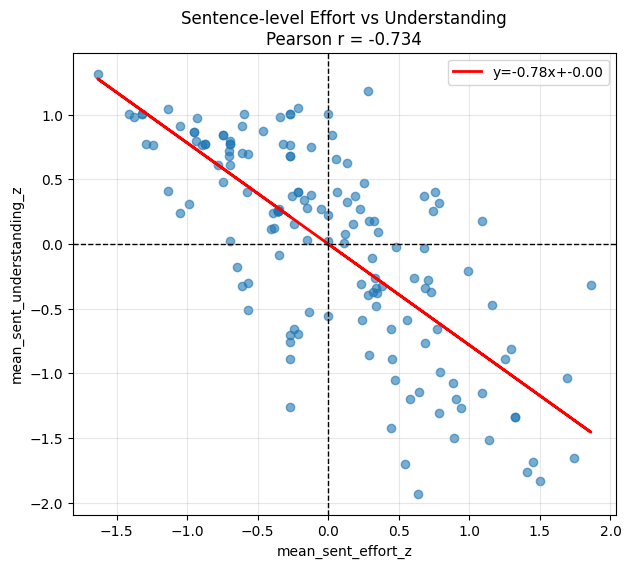

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr, pearsonr 

x = sent_agg['mean_sent_effort_z']
y = sent_agg['mean_sent_understanding_z']

# Fit line
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Plot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, line, color='red', linewidth=2, label=f"y={slope:.2f}x+{intercept:.2f}")

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel('mean_sent_effort_z')
plt.ylabel('mean_sent_understanding_z')
plt.title(f'Sentence-level Effort vs Understanding\nPearson r = {pearson_r:.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

/var/folders/97/83bqhl1s4sq_6bll23_84xz80000gn/T/ipykernel_15120/3263004534.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


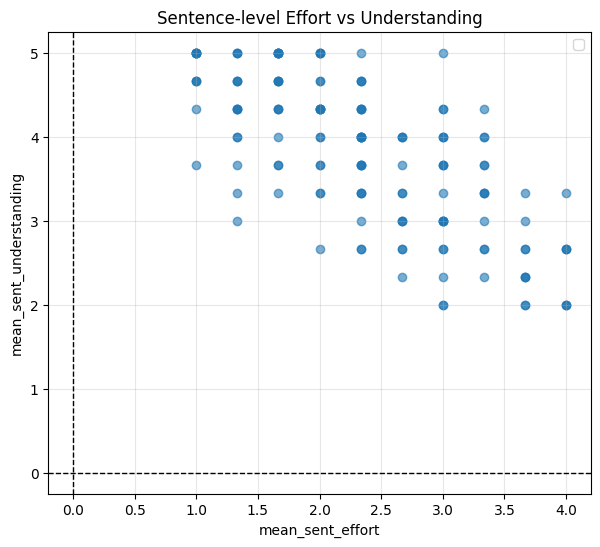

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr, pearsonr 

x = sent_agg['mean_sent_effort']
y = sent_agg['mean_sent_understanding']

# Fit line
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Plot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.6)
# plt.plot(x, line, color='red', linewidth=2, label=f"y={slope:.2f}x+{intercept:.2f}")

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel('mean_sent_effort')
plt.ylabel('mean_sent_understanding')
plt.title(f'Sentence-level Effort vs Understanding')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [57]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

def compute_worker_correlations(sent_agg):
    records = []

    for stim, group in sent_agg.groupby("stimulus_id"):
        group = group.sort_values("sent_idx")

        eff_lists = np.array(group["sent_effort_z_list"].tolist())        # shape (n_sent, n_workers)
        und_lists = np.array(group["sent_understanding_z_list"].tolist()) # shape (n_sent, n_workers)

        n_sent, n_workers = eff_lists.shape

        # For each worker (column)
        for w in range(n_workers):
            effort_vec = eff_lists[:, w]
            und_vec = und_lists[:, w]

            # Need at least 3 unique points for Kendall to make sense
            if n_sent < 3:
                continue

            tau, p = kendalltau(effort_vec, und_vec)

            records.append({
                "stimulus_id": stim,
                "worker_idx": w,
                "kendall_tau": tau,
                "n_sentences": n_sent
            })

    return pd.DataFrame(records)

worker_corr = compute_worker_correlations(sent_agg)
worker_corr.head()

,stimulus_id,worker_idx,kendall_tau,n_sentences
0,text_01,0,-0.848875,7
1,text_02,0,NaN,8
2,text_02,1,-0.733799,8
3,text_02,2,NaN,8
4,text_03,0,-0.562500,7


In [107]:
import pandas as pd

# Filter where both z-scores are below 0
low_both = sent_agg[
    (pd.to_numeric(sent_agg["mean_sent_effort_z"], errors="coerce") < 0)
    & (pd.to_numeric(sent_agg["mean_sent_understanding_z"], errors="coerce") < 0)
].copy()

print(f"Matches: {len(low_both)}")
low_both[["stimulus_id", "sent_idx", "mean_sent_effort_z", "mean_sent_understanding_z"]]

# If you want the sentence text, merge with sent_df you already built:
low_with_text = low_both.merge(sent_df[["stimulus_id", "sent_idx", "sentence"]], on=["stimulus_id", "sent_idx"], how="left")
low_with_text[["stimulus_id", "sent_idx", "sentence", "mean_sent_effort_z", "mean_sent_understanding_z"]]

Matches: 12


,stimulus_id,sent_idx,sentence,mean_sent_effort_z,mean_sent_understanding_z
0,text_04,7,"However, more important is that they have lowe...",-0.569912,-0.302465
1,text_07,3,The phenotype of those diagnosed with diabetes...,-0.272166,-0.761034
2,text_09,4,The specific etiology is not well understood a...,-0.272166,-1.258563
3,text_09,6,A cramp is almost never a local effect but inv...,-0.272166,-0.706147
4,text_12,1,The age distribution is bimodal with the highe...,-0.213252,-0.693055
5,text_13,0,C-reactive protein (CRP) is a phylogenetically...,-0.139214,-0.522233
6,text_13,5,This review will largely focus on our current ...,-0.645841,-0.174078
7,text_14,2,His only other medication was hydrocodone.,-0.241440,-0.660670
8,text_15,5,"This article addresses the prevalence, risk fa...",-0.350079,-0.086631
9,text_16,2,She was intubated for airway protection.,-0.613030,-0.324672


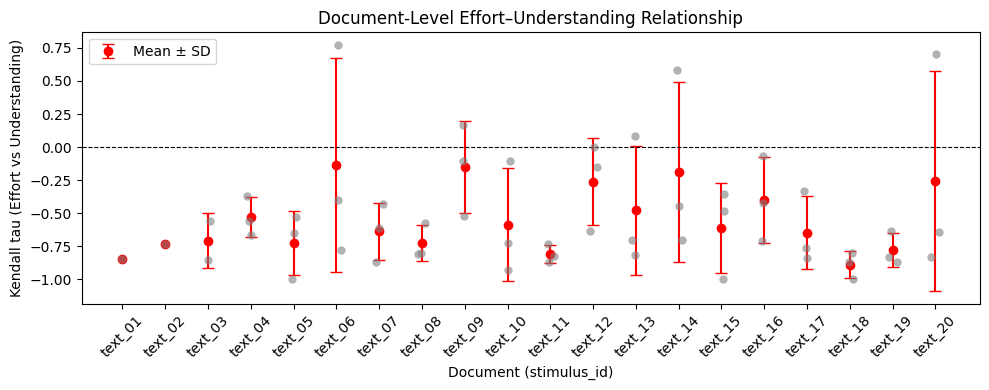

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_doc_level_kendall(worker_corr):

    # remove NaNs for averaging
    df = worker_corr.dropna(subset=["kendall_tau"])

    # compute mean & std per document
    summary = (
        df.groupby("stimulus_id")["kendall_tau"]
          .agg(["mean", "std", "count"])
          .reset_index()
    )

    plt.figure(figsize=(10, 4))
    
    # scatter workers
    sns.stripplot(
        data=df,
        x="stimulus_id",
        y="kendall_tau",
        color="gray",
        size=6,
        alpha=0.6
    )

    # mean + error bars
    plt.errorbar(
        summary["stimulus_id"],
        summary["mean"],
        yerr=summary["std"],
        fmt="o",
        color="red",
        capsize=4,
        label="Mean ± SD"
    )

    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.ylabel("Kendall tau (Effort vs Understanding)")
    plt.xlabel("Document (stimulus_id)")
    plt.title("Document-Level Effort–Understanding Relationship")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_doc_level_kendall(worker_corr)

In [18]:
def build_worker_vectors(sent_agg):
    records = []

    for stim, group in sent_agg.groupby("stimulus_id"):
        group = group.sort_values("sent_idx")

        eff = np.array(group["sent_effort_z_list"].tolist())   # (n_sent, n_workers)
        und = np.array(group["sent_understanding_z_list_rev"].tolist())

        n_sent, n_workers = eff.shape

        for w in range(n_workers):
            effort_vec = eff[:, w]
            und_vec = und[:, w]

            # simple concatenated vector
            combined_vec = np.concatenate([effort_vec, und_vec])

            records.append({
                "stimulus_id": stim,
                "worker_idx": w,
                "vector": combined_vec
            })

    return pd.DataFrame(records)

worker_vecs = build_worker_vectors(sent_agg)
worker_vecs.head()

,stimulus_id,worker_idx,vector
0,text_01,0,"[0.0, 1.3228756555322954, 0.0, 1.3228756555322..."
1,text_02,0,"[1.7320508075688774, 1.7320508075688774, -0.57..."
2,text_02,1,"[2.5, 0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,..."
3,text_02,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.645..."
4,text_03,0,"[0.0, 0.0, -1.3228756555322954, 0.0, -1.322875..."


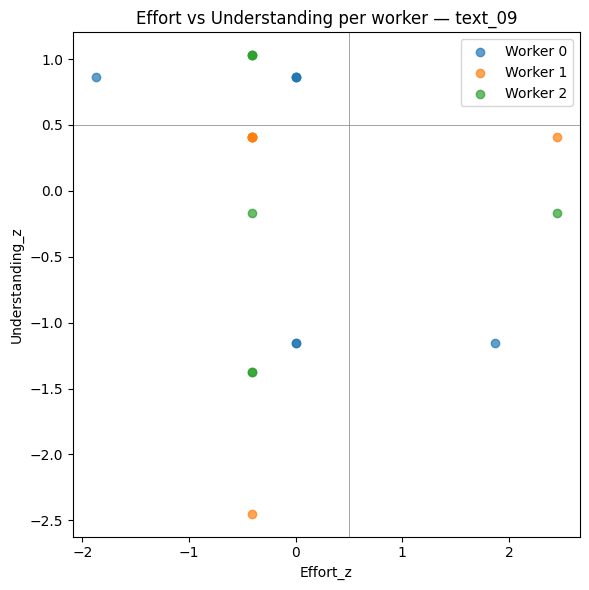

In [19]:
import matplotlib.pyplot as plt

def plot_worker_scatter(sent_agg, stim):
    df = sent_agg[sent_agg["stimulus_id"] == stim].sort_values("sent_idx")

    eff = np.array(df["sent_effort_z_list"].tolist())   # (n_sent, n_workers)
    und = np.array(df["sent_understanding_z_list"].tolist())

    n_sent, n_workers = eff.shape

    plt.figure(figsize=(6, 6))

    for w in range(n_workers):
        plt.scatter(eff[:, w], und[:, w], label=f"Worker {w}", alpha=0.7)

    plt.xlabel("Effort_z")
    plt.ylabel("Understanding_z")
    plt.title(f"Effort vs Understanding per worker — {stim}")
    plt.axhline(0.5, color="gray", lw=0.5)
    plt.axvline(0.5, color="gray", lw=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_worker_scatter(sent_agg, stim=sent_agg["stimulus_id"].unique()[8])

### Per-document difficulty curves

In [101]:
# def plot_difficulty_curves(sent_agg, stimulus_id):
#     df = sent_agg[sent_agg["stimulus_id"] == stimulus_id].sort_values("sent_idx")

#     plt.figure(figsize=(8, 4))
#     plt.plot(df["sent_idx"], df["mean_sent_effort_z"], marker="o", label="Effort (z)")
#     plt.plot(df["sent_idx"], df["mean_sent_understanding_z"], marker="o", label="Understanding (z)")
#     plt.xlabel("Sentence index")
#     plt.ylabel("Mean z-score")
#     plt.title(f"Difficulty curve for {stimulus_id}")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# Example: plot for all documents in a loop (or pick a few)
# for stim in sent_agg["stimulus_id"].unique():
#     plot_difficulty_curves(sent_agg, stim)

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, spearmanr, pearsonr

def compute_doc_agreement(sent_agg, value_col):
    """
    Compute mean pairwise correlation (Kendall, Spearman, Pearson) across workers
    for each stimulus_id, using list column value_col
    (e.g., 'sent_effort_list' or 'sent_understanding_list').

    Returns a DataFrame with:
    stimulus_id, n_workers, n_sentences, mean_kendall, mean_spearman, mean_pearson
    """
    records = []

    for stim, group in sent_agg.groupby("stimulus_id"):
        # shape: (n_sent, n_workers)
        lists = group[value_col].tolist()
        if len(lists) == 0:
            continue

        mat = np.array(lists, dtype=float)
        n_sent, n_workers = mat.shape

        if n_workers < 2:
            # cannot compute pairwise correlations
            continue

        kendalls = []
        spearmans = []
        pearsons = []

        # pairwise over workers
        for i in range(n_workers):
            for j in range(i + 1, n_workers):
                x = mat[:, i]
                y = mat[:, j]

                # Skip pairs with no variance
                if (np.all(x == x[0]) and np.all(y == y[0])) or \
                   (np.std(x) == 0 or np.std(y) == 0):
                    continue

                ktau, _ = kendalltau(x, y, nan_policy="omit")
                srho, _ = spearmanr(x, y, nan_policy="omit")
                prho, _ = pearsonr(x, y)

                if not np.isnan(ktau):
                    kendalls.append(ktau)
                if not np.isnan(srho):
                    spearmans.append(srho)
                if not np.isnan(prho):
                    pearsons.append(prho)

        mean_kendall = float(np.mean(kendalls)) if kendalls else np.nan
        mean_spearman = float(np.mean(spearmans)) if spearmans else np.nan
        mean_pearson = float(np.mean(pearsons)) if pearsons else np.nan

        records.append({
            "stimulus_id": stim,
            "n_sentences": n_sent,
            "n_workers": n_workers,
            "mean_kendall": mean_kendall,
            "mean_spearman": mean_spearman,
            "mean_pearson": mean_pearson,
        })

    return pd.DataFrame(records)

In [44]:
# Effort agreement per document
eff_agree = compute_doc_agreement(sent_agg, "sent_effort_list")
eff_agree.rename(columns={
    "mean_kendall": "eff_kendall",
    "mean_spearman": "eff_spearman",
    "mean_pearson": "eff_pearson",
}, inplace=True)

# Understanding agreement per document
und_agree = compute_doc_agreement(sent_agg, "sent_understanding_list")
und_agree.rename(columns={
    "mean_kendall": "und_kendall",
    "mean_spearman": "und_spearman",
    "mean_pearson": "und_pearson",
}, inplace=True)

# Merge as before
doc_agree = eff_agree.merge(
    und_agree,
    on=["stimulus_id", "n_sentences", "n_workers"],
    how="outer"
)

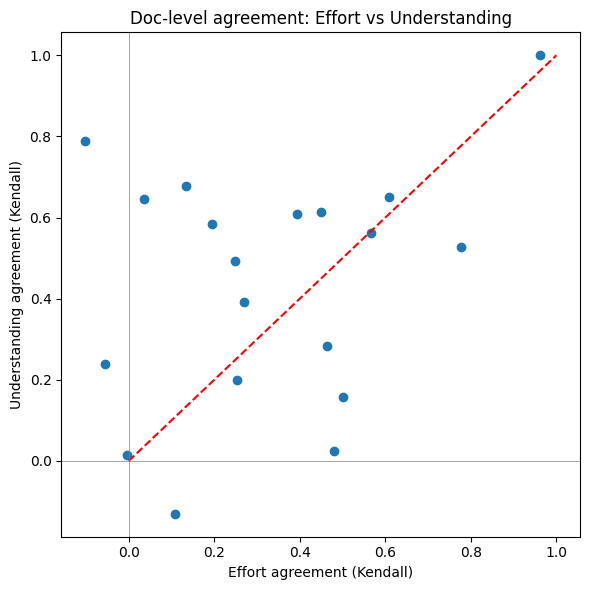

In [46]:
plt.figure(figsize=(6, 6)) 
plt.scatter(doc_agree["eff_kendall"], doc_agree["und_kendall"]) 
plt.xlabel("Effort agreement (Kendall)") 
plt.ylabel("Understanding agreement (Kendall)") 
plt.title("Doc-level agreement: Effort vs Understanding") 
plt.plot([0, 1], [0, 1], color="red", linestyle="--") 
plt.axhline(0, color="gray", linewidth=0.5) 
plt.axvline(0, color="gray", linewidth=0.5) 
plt.tight_layout() 
plt.show()

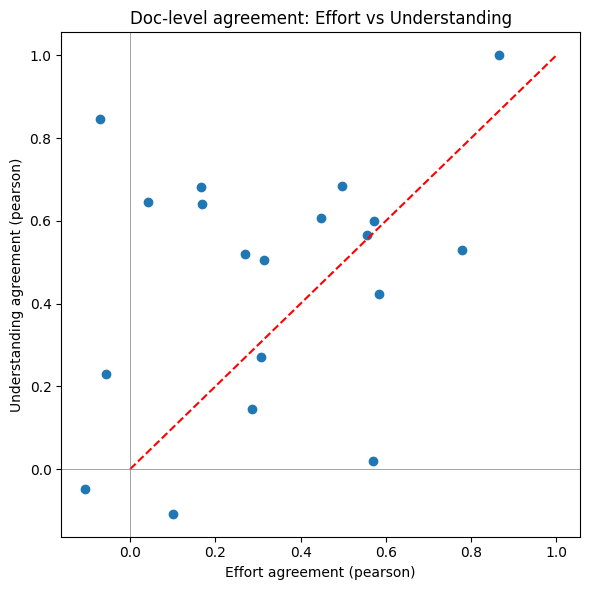

In [47]:
plt.figure(figsize=(6, 6)) 
plt.scatter(doc_agree["eff_pearson"], doc_agree["und_pearson"]) 
plt.xlabel("Effort agreement (pearson)") 
plt.ylabel("Understanding agreement (pearson)") 
plt.title("Doc-level agreement: Effort vs Understanding") 
plt.plot([0, 1], [0, 1], color="red", linestyle="--") 
plt.axhline(0, color="gray", linewidth=0.5) 
plt.axvline(0, color="gray", linewidth=0.5) 
plt.tight_layout() 
plt.show()

In [51]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sort by stimulus_id to keep the x-axis ordered
# doc_agree_sorted = doc_agree.sort_values("stimulus_id")

# x = np.arange(len(doc_agree_sorted))  # positions for each stimulus
# width = 0.35                          # width of each bar

# fig, ax = plt.subplots(figsize=(10, 6))

# # Bars
# bars1 = ax.bar(
#     x - width/2,
#     doc_agree_sorted["eff_kendall"],
#     width,
#     label="Effort (Kendall)"
# )

# bars2 = ax.bar(
#     x + width/2,
#     doc_agree_sorted["und_kendall"],
#     width,
#     label="Understanding (Kendall)"
# )

# # Labels & ticks
# ax.set_xlabel("Stimulus ID")
# ax.set_ylabel("Kendall Agreement")
# ax.set_title("Document-Level Agreement per Stimulus (Effort vs Understanding)")
# ax.set_xticks(x)
# ax.set_xticklabels(doc_agree_sorted["stimulus_id"], rotation=45, ha="right")

# ax.legend()
# plt.tight_layout()
# plt.show()

/var/folders/97/83bqhl1s4sq_6bll23_84xz80000gn/T/ipykernel_4577/3421251304.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr, _ = pearsonr(e, u)
/var/folders/97/83bqhl1s4sq_6bll23_84xz80000gn/T/ipykernel_4577/3421251304.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sr, _ = spearmanr(e, u, nan_policy="omit")


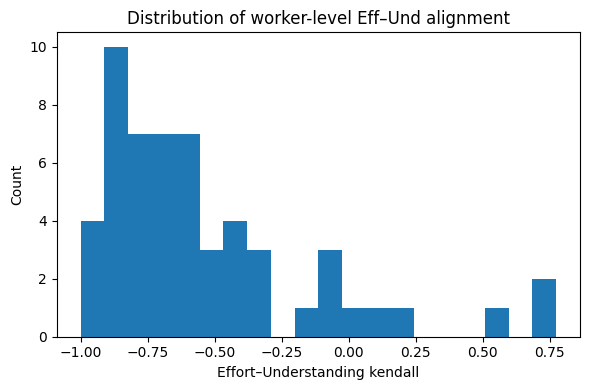

In [22]:
def compute_worker_eff_und_alignment(sent_agg):
    """
    Compute, for each stimulus_id and each worker index, the correlation
    between effort_z and understanding_z across sentences.

    Returns a DataFrame with:
    stimulus_id, worker_idx, n_sentences, pearson_r, kendall_tau, spearman_r
    """
    records = []

    for stim, group in sent_agg.groupby("stimulus_id"):
        group = group.sort_values("sent_idx")
        eff_lists = group["sent_effort_z_list"].tolist()
        und_lists = group["sent_understanding_z_list"].tolist()

        if len(eff_lists) == 0:
            continue

        eff_mat = np.array(eff_lists, dtype=float)   # (n_sent, n_workers)
        und_mat = np.array(und_lists, dtype=float)
        n_sent, n_workers = eff_mat.shape

        if n_sent < 2:
            continue

        for w in range(n_workers):
            e = eff_mat[:, w]
            u = und_mat[:, w]

            # Skip workers with no variation at all in both
            if np.all(e == e[0]) and np.all(u == u[0]):
                continue

            # Pearson
            try:
                pr, _ = pearsonr(e, u)
            except Exception:
                pr = np.nan

            # Kendall
            kt, _ = kendalltau(e, u, nan_policy="omit")

            # Spearman
            sr, _ = spearmanr(e, u, nan_policy="omit")

            records.append({
                "stimulus_id": stim,
                "worker_idx": w,
                "n_sentences": n_sent,
                "pearson_r": pr,
                "kendall_tau": kt,
                "spearman_r": sr
            })

    return pd.DataFrame(records)


worker_align = compute_worker_eff_und_alignment(sent_agg)

# Example: histogram of Pearson correlations across all workers
plt.figure(figsize=(6, 4))
plt.hist(worker_align["kendall_tau"].dropna(), bins=20)
plt.xlabel("Effort–Understanding kendall")
plt.ylabel("Count")
plt.title("Distribution of worker-level Eff–Und alignment")
plt.tight_layout()
plt.show()


### Inspect missed quizzes effort/understanding

In [23]:
import json
import pandas as pd

def safe_load_quiz(val):
    try:
        return json.loads(val) if isinstance(val, str) else []
    except Exception:
        return []

quiz_rows = []
for _, r in raw.iterrows():
    for q in safe_load_quiz(r["quiz_results"]):
        quiz_rows.append(
            {
                "worker_id": r["worker_id"],
                "stimulus_id": r["stimulus_id"],
                "sent_idx": int(q.get("sentence_id", -1)),  # assumes 0-based
                "is_correct": q.get("is_correct"),
                "quiz_effort": pd.to_numeric(q.get("effort_rating"), errors="coerce"),
                "quiz_confidence": pd.to_numeric(q.get("confidence_rating"), errors="coerce"),
            }
        )

# Parse quizzes as before...
quiz_df = pd.DataFrame(quiz_rows)
quiz_df["sent_idx"] = quiz_df["sent_idx"] - 1  # convert 1-based -> 0-based

wrong_quiz = quiz_df[quiz_df["is_correct"] == False].copy()

wrong_quiz["quiz_confidence"] = pd.to_numeric(wrong_quiz["quiz_confidence"], errors="coerce")
quiz_conf_dist = wrong_quiz["quiz_confidence"].value_counts(dropna=False).sort_index()
quiz_conf_summary = wrong_quiz["quiz_confidence"].describe()

cols = ["worker_id", "stimulus_id", "sent_idx", "sent_effort", "sent_understanding"]
wrong_annot = wrong_quiz.merge(worker_sent_df[cols], on=["worker_id", "stimulus_id", "sent_idx"], how="left")

effort_dist = wrong_annot["sent_effort"].value_counts(dropna=False).sort_index()
understanding_dist = wrong_annot["sent_understanding"].value_counts(dropna=False).sort_index()
conf_dist = wrong_quiz["quiz_confidence"].value_counts(dropna=False).sort_index()

effort_dist, understanding_dist, conf_dist

(sent_effort
 1    7
 2    5
 3    6
 4    6
 5    3
 Name: count, dtype: int64,
 sent_understanding
 1    4
 2    8
 3    5
 4    5
 5    5
 Name: count, dtype: int64,
 quiz_confidence
 1     6
 2    10
 3     4
 4     1
 5     6
 Name: count, dtype: int64)

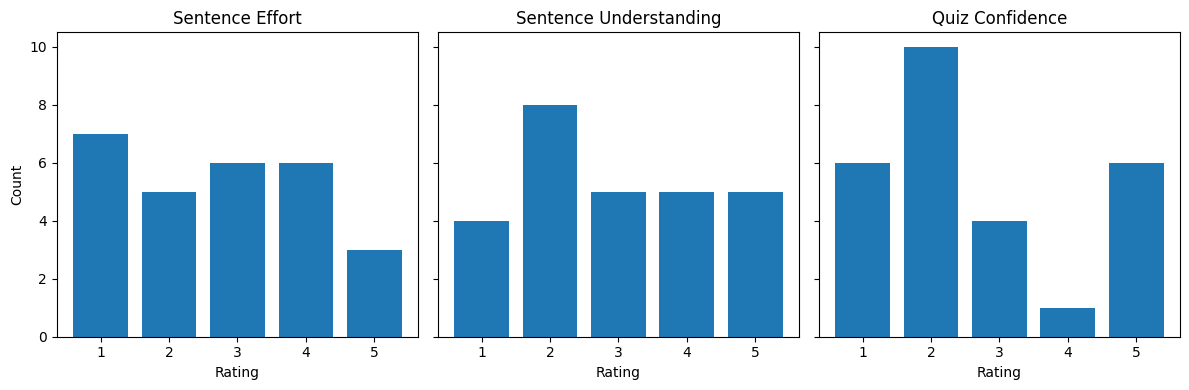

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all 1–5 ratings are present, even if count is 0
rating_index = pd.Index([1, 2, 3, 4, 5], name="rating")

eff = effort_dist.reindex(rating_index, fill_value=0)
under = understanding_dist.reindex(rating_index, fill_value=0)
conf = conf_dist.reindex(rating_index, fill_value=0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].bar(eff.index, eff.values)
axes[0].set_title("Sentence Effort")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")
axes[0].set_xticks([1, 2, 3, 4, 5])

axes[1].bar(under.index, under.values)
axes[1].set_title("Sentence Understanding")
axes[1].set_xlabel("Rating")
axes[1].set_xticks([1, 2, 3, 4, 5])

axes[2].bar(conf.index, conf.values)
axes[2].set_title("Quiz Confidence")
axes[2].set_xlabel("Rating")
axes[2].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

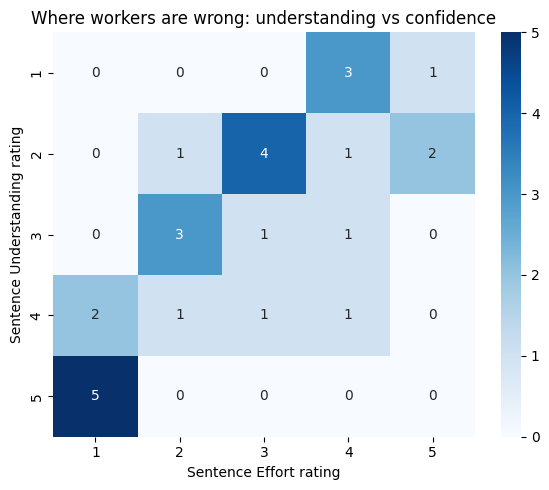

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# wrong_annot already has sent_understanding + quiz_confidence for wrong answers
heat = pd.crosstab(
    wrong_annot["sent_understanding"],
    # wrong_annot["quiz_confidence"]
    wrong_annot["sent_effort"],
).reindex(index=[1,2,3,4,5], columns=[1,2,3,4,5], fill_value=0)

plt.figure(figsize=(6, 5))
sns.heatmap(
    heat,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Sentence Effort rating")
plt.ylabel("Sentence Understanding rating")
plt.title("Where workers are wrong: understanding vs confidence")
plt.tight_layout()
plt.show()

In [25]:
# With wrong_quiz already filtered to is_correct == False and sent_idx shifted to 0-based
miss_counts = (
    wrong_quiz
    .groupby(["worker_id", "stimulus_id", "sent_idx"], dropna=False)
    .size()
    .reset_index(name="n_wrong")
    .sort_values("n_wrong", ascending=False)
)

miss_counts.head(16)  # shows any repeats (>1)
# Totals per worker if useful:
wrong_quiz.groupby("worker_id").size().sort_values(ascending=False)

worker_id
66cc6eb364154a51d4d44eb1    4
5b13da851e55760001ba009a    3
576ef8ede26bd40001ebf904    2
5ee637a18976fc391312fe01    2
63bed6e176fba857a47fbaff    2
60c0fa09ef735c52ada64d23    2
5bf2f728bd9f150001f6cc42    2
5ec79cbd44972a1fceed2719    1
5f15076a6b42b74b6ba223a8    1
5aad8499e1546900019aef29    1
5ebc0abd2cc5f1054c82a0d7    1
651ac88823e71c05dbc1ff63    1
6668c9df1d76dc85e0f95d40    1
66d30652285b78a5610f7c36    1
672541915a9a5ac8b878a28e    1
6766005e976f31a2da5b91fc    1
693075f3ce1b1264d296a86b    1
dtype: int64

In [26]:
# wrong_quiz already filtered to is_correct == False and sent_idx is 0-based
question_wrong_counts = (
    wrong_quiz
    .groupby(["stimulus_id", "sent_idx"], dropna=False)
    .size()
    .reset_index(name="n_wrong")
    .sort_values("n_wrong", ascending=False)
)

question_wrong_counts.head(16)  # top items with the most wrong answers

,stimulus_id,sent_idx,n_wrong
2,text_05,0,2
11,text_10,2,2
1,text_04,7,2
0,text_04,1,1
14,text_13,4,1
22,text_18,4,1
21,text_18,2,1
20,text_16,10,1
19,text_16,5,1
18,text_14,9,1


### Correctly answered confidence inspection

In [27]:
correct_quiz = quiz_df[quiz_df["is_correct"] == True].copy()

# Merge to pull sentence-level ratings
cols = ["worker_id", "stimulus_id", "sent_idx", "sent_effort", "sent_understanding"]
correct_annot = correct_quiz.merge(worker_sent_df[cols], on=["worker_id", "stimulus_id", "sent_idx"], how="left")

# Distributions
effort_dist_ok = correct_annot["sent_effort"].value_counts(dropna=False).sort_index()
understanding_dist_ok = correct_annot["sent_understanding"].value_counts(dropna=False).sort_index()
correct_quiz["quiz_confidence"] = pd.to_numeric(correct_quiz["quiz_confidence"], errors="coerce")
conf_dist_ok = correct_quiz["quiz_confidence"].value_counts(dropna=False).sort_index()

# Optional summary stats
summary_ok = correct_annot[["sent_effort", "sent_understanding"]].describe()
conf_summary_ok = correct_quiz["quiz_confidence"].describe()

effort_dist_ok, understanding_dist_ok, conf_dist_ok, summary_ok, conf_summary_ok

(sent_effort
 1    57
 2    52
 3    50
 4    35
 5    11
 Name: count, dtype: int64,
 sent_understanding
 1     5
 2    29
 3    48
 4    54
 5    69
 Name: count, dtype: int64,
 quiz_confidence
 1     5
 2    15
 3    33
 4    69
 5    83
 Name: count, dtype: int64,
        sent_effort  sent_understanding
 count   205.000000          205.000000
 mean      2.468293            3.746341
 std       1.214786            1.139336
 min       1.000000            1.000000
 25%       1.000000            3.000000
 50%       2.000000            4.000000
 75%       3.000000            5.000000
 max       5.000000            5.000000,
 count    205.000000
 mean       4.024390
 std        1.040546
 min        1.000000
 25%        3.000000
 50%        4.000000
 75%        5.000000
 max        5.000000
 Name: quiz_confidence, dtype: float64)

## Sentence features

In [28]:
sent_df.head()

,stimulus_id,sent_idx,sentence,readability
0,text_01,0,The detection of chemical compounds in exhaled...,4.025040
1,text_01,1,Recent advancements in metabolomics research h...,4.305226
2,text_01,2,Despite some notable challenges in sampling an...,4.333728
3,text_01,3,Several breath-based tests that target either ...,4.303588
4,text_01,4,This review outlines the concept of breath ana...,3.812681


In [29]:
import re

def tokenize(text):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text.lower())

def count_syllables(word):
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    prev_is_vowel = False
    for ch in word:
        is_vowel = ch in vowels
        if is_vowel and not prev_is_vowel:
            count += 1
        prev_is_vowel = is_vowel
    if word.endswith("e") and count > 1:
        count -= 1
    return max(count, 1)

def sentence_features(text):
    words = tokenize(text)
    word_count = len(words)
    char_count = len(text)
    unique_ratio = len(set(words)) / word_count if word_count else 0
    avg_word_len = sum(len(w) for w in words) / word_count if word_count else 0

    syllables = [count_syllables(w) for w in words] if words else []
    syllables_total = sum(syllables)
    syllables_per_word = syllables_total / word_count if word_count else 0
    polysyllable_count = sum(1 for s in syllables if s >= 3)
    long_word_share = sum(1 for w in words if len(w) >= 6) / word_count if word_count else 0

    # Automated Readability Index with sentences=1 for each row
    ari = 4.71 * (char_count / word_count) + 0.5 * 1 - 21.43 if word_count else 0

    return pd.Series(
        {
            "char_len": char_count,
            "word_count": word_count,
            "avg_word_len": avg_word_len,
            "unique_word_ratio": unique_ratio,
            "syllables_per_word": syllables_per_word,
            "polysyllable_count": polysyllable_count,
            "long_word_share": long_word_share,
            "ari_est": ari,
        }
    )

sent_df = sent_df.join(sent_df["sentence"].apply(sentence_features))

In [30]:
import spacy

# Load parser (installs en_core_web_sm if missing)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def _dep_depth(tok):
    if not list(tok.children):
        return 1
    return 1 + max(_dep_depth(child) for child in tok.children)

def sentence_tree_depth(text):
    doc = nlp(text)
    roots = [t for t in doc if t.head == t]
    return max(_dep_depth(r) for r in roots) if roots else None

# Add to your sent_df
sent_df["tree_depth"] = sent_df["sentence"].apply(sentence_tree_depth)
sent_df[["stimulus_id", "sent_idx", "tree_depth"]].head()


,stimulus_id,sent_idx,tree_depth
0,text_01,0,8
1,text_01,1,7
2,text_01,2,6
3,text_01,3,8
4,text_01,4,10


In [63]:
from scipy.stats import kendalltau, spearmanr, pearsonr
import pandas as pd

keys = ["stimulus_id", "sent_idx"]

# aggregated features (columns / heatmap columns)
feature_cols = [
    "mean_sent_effort_z",
    "std_sent_effort_z",
    "mean_sent_understanding_z_rev",
    "std_sent_understanding_z",
]

# sentence-level features (rows / heatmap rows)
exclude_cols = ["unique_word_ratio", "long_word_share"]
sent_feature_cols = [
    col for col in sent_df.select_dtypes(include="number").columns
    if col not in keys and col not in exclude_cols
]

agg_cols = keys + feature_cols
sent_agg_small = sent_agg[agg_cols]

merged = sent_df.merge(sent_agg_small, on=keys, how="inner")

In [64]:
results = []

for s_col in sent_feature_cols:
    for a_col in feature_cols:
        # Drop NAs pairwise
        valid = merged[[s_col, a_col]].dropna()
        if len(valid) < 2:
            # not enough data to compute correlation
            continue

        x = valid[s_col]
        y = valid[a_col]

        # Kendall
        tau, tau_p = kendalltau(x, y)
        results.append({
            "sent_feature": s_col,
            "agg_feature": a_col,
            "metric": "kendall_tau",
            "corr": tau,
            "p_value": tau_p,
            "n": len(valid),
        })

        # Spearman
        rho, rho_p = spearmanr(x, y)
        results.append({
            "sent_feature": s_col,
            "agg_feature": a_col,
            "metric": "spearman_rho",
            "corr": rho,
            "p_value": rho_p,
            "n": len(valid),
        })

        # Pearson
        r, r_p = pearsonr(x, y)
        results.append({
            "sent_feature": s_col,
            "agg_feature": a_col,
            "metric": "pearson_r",
            "corr": r,
            "p_value": r_p,
            "n": len(valid),
        })

results_long = pd.DataFrame(results)

In [65]:
# Kendall heatmap matrix
heat_kendall = (
    results_long[results_long["metric"] == "kendall_tau"]
    .pivot(index="sent_feature", columns="agg_feature", values="corr")
)

# Spearman heatmap matrix
heat_spearman = (
    results_long[results_long["metric"] == "spearman_rho"]
    .pivot(index="sent_feature", columns="agg_feature", values="corr")
)

# Pearson heatmap matrix
heat_pearson = (
    results_long[results_long["metric"] == "pearson_r"]
    .pivot(index="sent_feature", columns="agg_feature", values="corr")
)

In [66]:
heat_pearson

agg_feature,mean_sent_effort_z,mean_sent_understanding_z_rev,std_sent_effort_z,std_sent_understanding_z
sent_feature,,,,
ari_est,0.119075,0.103077,-0.059150,0.067232
avg_word_len,0.101615,0.077491,-0.067419,0.003422
char_len,0.309059,0.129302,0.027880,-0.081192
polysyllable_count,0.336993,0.207485,0.003814,-0.006424
readability,0.481965,0.417571,0.207197,0.242276
syllables_per_word,0.176985,0.181687,-0.011062,0.107639
tree_depth,0.126754,-0.078939,-0.125850,-0.176250
word_count,0.283398,0.102338,0.046207,-0.093849


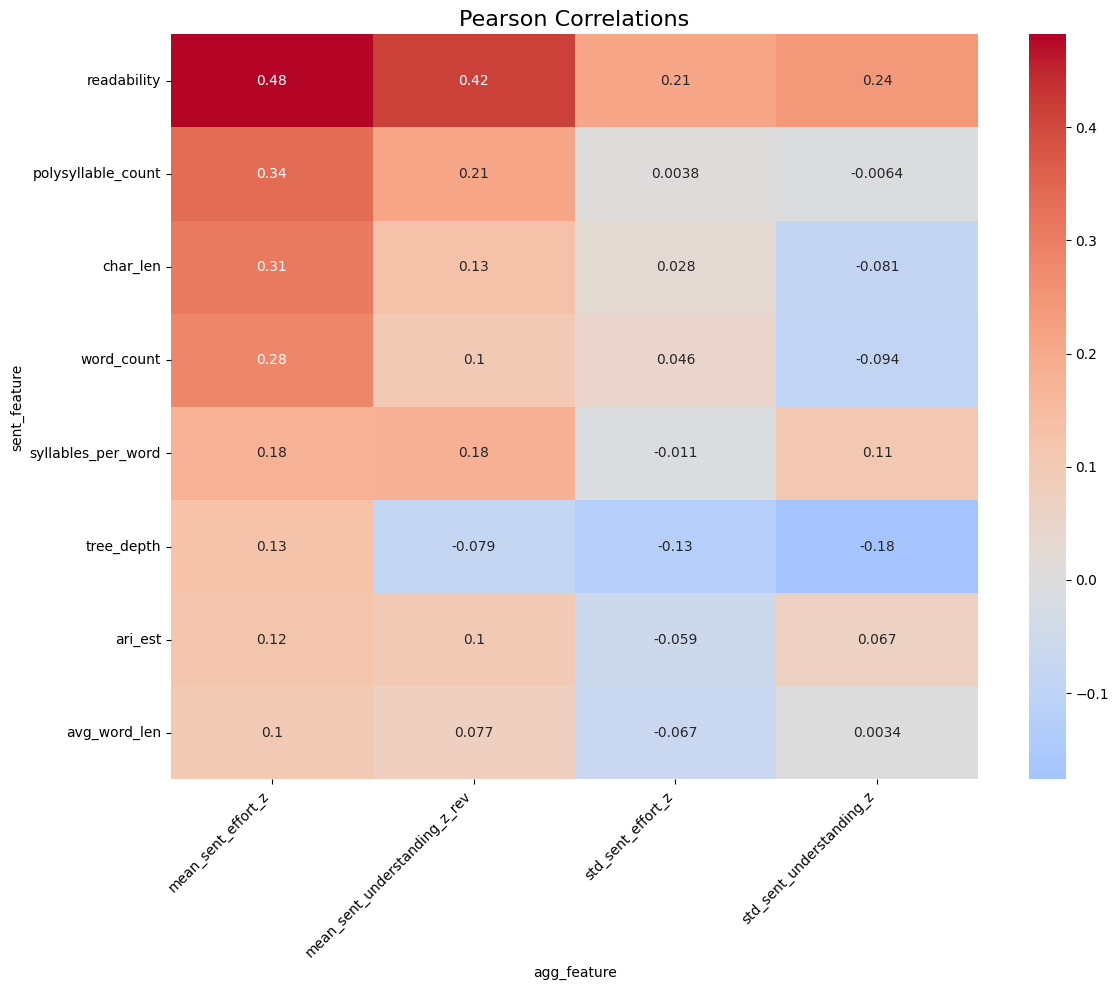

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

target_col = "mean_sent_effort_z"

# Sort row index by this column
row_order = heat_pearson[target_col].sort_values(ascending=False).index

heat_sorted = heat_pearson.loc[row_order, :]  # rows reordered, columns unchanged

plt.figure(figsize=(12, 10))
sns.heatmap(
    heat_sorted,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title(f"Pearson Correlations", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Document Features

In [35]:
import pandas as pd, json
from pathlib import Path
import numpy as np

# ---------- Load raw worker responses ----------
raw_df = pd.read_csv("../results/round2_1208.csv")

def safe_json(val, default):
    try:
        return json.loads(val) if isinstance(val, str) else default
    except Exception:
        return default

raw_df["familiarity_parsed"] = raw_df["familiarity"].apply(lambda x: safe_json(x, {}))
raw_df["annotations_parsed"] = raw_df["annotations"].apply(lambda x: safe_json(x, []))
raw_df["quiz_parsed"] = raw_df["quiz_results"].apply(lambda x: safe_json(x, []))

# ---------- Per-worker-per-doc (doc-level) ----------
def mean_or_nan(vals):
    vals = pd.to_numeric(vals, errors="coerce")
    return vals.mean() if len(vals) else np.nan

worker_doc_df = pd.DataFrame({
    "worker_id": raw_df["worker_id"],
    "study_id": raw_df["study_id"],
    "session_id": raw_df["session_id"],
    "stimulus_id": raw_df["stimulus_id"],
    "overall_difficulty": pd.to_numeric(raw_df["overall_difficulty"], errors="coerce"),
    "confidence_doc": pd.to_numeric(raw_df["confidence"], errors="coerce"),
    "improvements": raw_df["improvements"].fillna(""),
    "topic_familiarity": raw_df["familiarity_parsed"].apply(lambda d: pd.to_numeric(d.get("topic_familiarity"), errors="coerce")),
    "reading_exposure_str": raw_df["familiarity_parsed"].apply(lambda d: "; ".join(d.get("reading_exposure", []))),
    "n_sentences_rated": raw_df["annotations_parsed"].apply(len),
    "mean_sent_effort_worker": raw_df["annotations_parsed"].apply(lambda ann: mean_or_nan([a.get("rating") for a in ann])),
    "mean_sent_conf_worker": raw_df["annotations_parsed"].apply(lambda ann: mean_or_nan([a.get("confidence") for a in ann])),
    "quiz_correct_rate_worker": raw_df["quiz_parsed"].apply(lambda qs: np.mean([q.get("is_correct") for q in qs]) if qs else np.nan),
    "mean_quiz_effort_worker": raw_df["quiz_parsed"].apply(lambda qs: mean_or_nan([q.get("effort_rating") for q in qs]) if qs else np.nan),
    "mean_quiz_conf_worker": raw_df["quiz_parsed"].apply(lambda qs: mean_or_nan([q.get("confidence_rating") for q in qs]) if qs else np.nan),
}).sort_values(["stimulus_id", "worker_id"]).reset_index(drop=True)

# ---------- Aggregate across workers per doc ----------
doc_agg = (
    worker_doc_df.groupby("stimulus_id")
    .agg({
        "overall_difficulty": "mean",
        "confidence_doc": "mean",
        "mean_sent_effort_worker": "mean",
        "mean_sent_conf_worker": "mean",
        "quiz_correct_rate_worker": "mean",
        "mean_quiz_effort_worker": "mean",
        "mean_quiz_conf_worker": "mean",
        "worker_id": "nunique",
    })
    .rename(columns={"worker_id": "n_workers"})
    .reset_index()
)

# ---------- Doc text/readability info ----------
with Path("../data/PLABA_sample_stratified.json").open() as f:
    docs = json.load(f)

doc_text_df = pd.DataFrame([{
    "stimulus_id": d["text_id"],
    "doc_id": d.get("doc_id"),
    "abstract_text": d["data"]["abstract_text"],
    "abstract_readability_avg": d.get("abstract_readability_avg"),
    "n_sentences": len(d["data"]["abstract"]),
} for d in docs])


In [36]:
import pandas as pd
from readability import Readability

def readability_scores(text):
    r = Readability(text)
    def safe(fn):
        try:
            return fn().score
        except Exception:
            return None  # short texts or edge cases can throw
    return pd.Series({
        "flesch_kincaid": safe(r.flesch_kincaid),
        "flesch": safe(r.flesch),
        "gunning_fog": safe(r.gunning_fog),
        "coleman_liau": safe(r.coleman_liau),
        "dale_chall": safe(r.dale_chall),
        "ari": safe(r.ari),
        "linsear_write": safe(r.linsear_write),
        "smog": safe(r.smog),
        "spache": safe(r.spache),
    })

doc_text_df = doc_text_df.join(doc_text_df["abstract_text"].apply(readability_scores))
doc_text_df.head()


,stimulus_id,doc_id,abstract_text,abstract_readability_avg,n_sentences,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
0,text_01,34576985,The detection of chemical compounds in exhaled...,4.109488,7,17.109447,10.247742,20.986175,18.484645,11.967624,18.174912,18.214286,NaN,8.510820
1,text_02,16995969,Chronic throat clearing or a feeling of 'somet...,3.900713,8,13.345218,31.221900,16.309060,15.522953,9.964931,14.245856,13.937500,NaN,7.101367
2,text_03,8857777,The use of wound dressings that are based on t...,4.190527,7,14.890110,26.403462,18.145055,15.701795,11.017384,16.010357,16.714286,NaN,8.501799
3,text_04,24371979,Compression therapy is the basic therapy in ph...,4.132829,9,13.012585,29.689320,15.240816,17.907755,10.247041,15.188912,12.277778,NaN,6.944721
4,text_05,31420757,Tardive dyskinesia (TD) is caused by exposure ...,4.122622,10,13.715266,23.739772,16.699747,15.931899,11.515686,13.388544,12.400000,NaN,7.584522


In [37]:
# Example merge: doc-level scores + text
doc_full = doc_agg.merge(doc_text_df, on="stimulus_id", how="left")
doc_full.head()

,stimulus_id,overall_difficulty,confidence_doc,mean_sent_effort_worker,mean_sent_conf_worker,quiz_correct_rate_worker,mean_quiz_effort_worker,mean_quiz_conf_worker,n_workers,doc_id,...,n_sentences,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
0,text_01,3.000000,3.000000,3.000000,3.714286,1.00,2.750000,3.750000,1,34576985,...,7,17.109447,10.247742,20.986175,18.484645,11.967624,18.174912,18.214286,NaN,8.510820
1,text_02,2.666667,4.333333,1.916667,4.750000,1.00,1.888889,3.666667,3,16995969,...,8,13.345218,31.221900,16.309060,15.522953,9.964931,14.245856,13.937500,NaN,7.101367
2,text_03,2.000000,3.666667,1.619048,4.333333,1.00,1.833333,4.416667,3,8857777,...,7,14.890110,26.403462,18.145055,15.701795,11.017384,16.010357,16.714286,NaN,8.501799
3,text_04,3.666667,3.333333,2.296296,3.925926,0.75,2.416667,3.333333,3,24371979,...,9,13.012585,29.689320,15.240816,17.907755,10.247041,15.188912,12.277778,NaN,6.944721
4,text_05,3.000000,3.333333,2.233333,4.233333,0.75,2.916667,3.666667,3,31420757,...,10,13.715266,23.739772,16.699747,15.931899,11.515686,13.388544,12.400000,NaN,7.584522


In [78]:
worker_doc_df.columns

Index(['worker_id', 'study_id', 'session_id', 'stimulus_id',
       'overall_difficulty', 'confidence_doc', 'improvements',
       'topic_familiarity', 'reading_exposure_str', 'n_sentences_rated',
       'mean_sent_effort_worker', 'mean_sent_conf_worker',
       'quiz_correct_rate_worker', 'mean_quiz_effort_worker',
       'mean_quiz_conf_worker'],
      dtype='object')

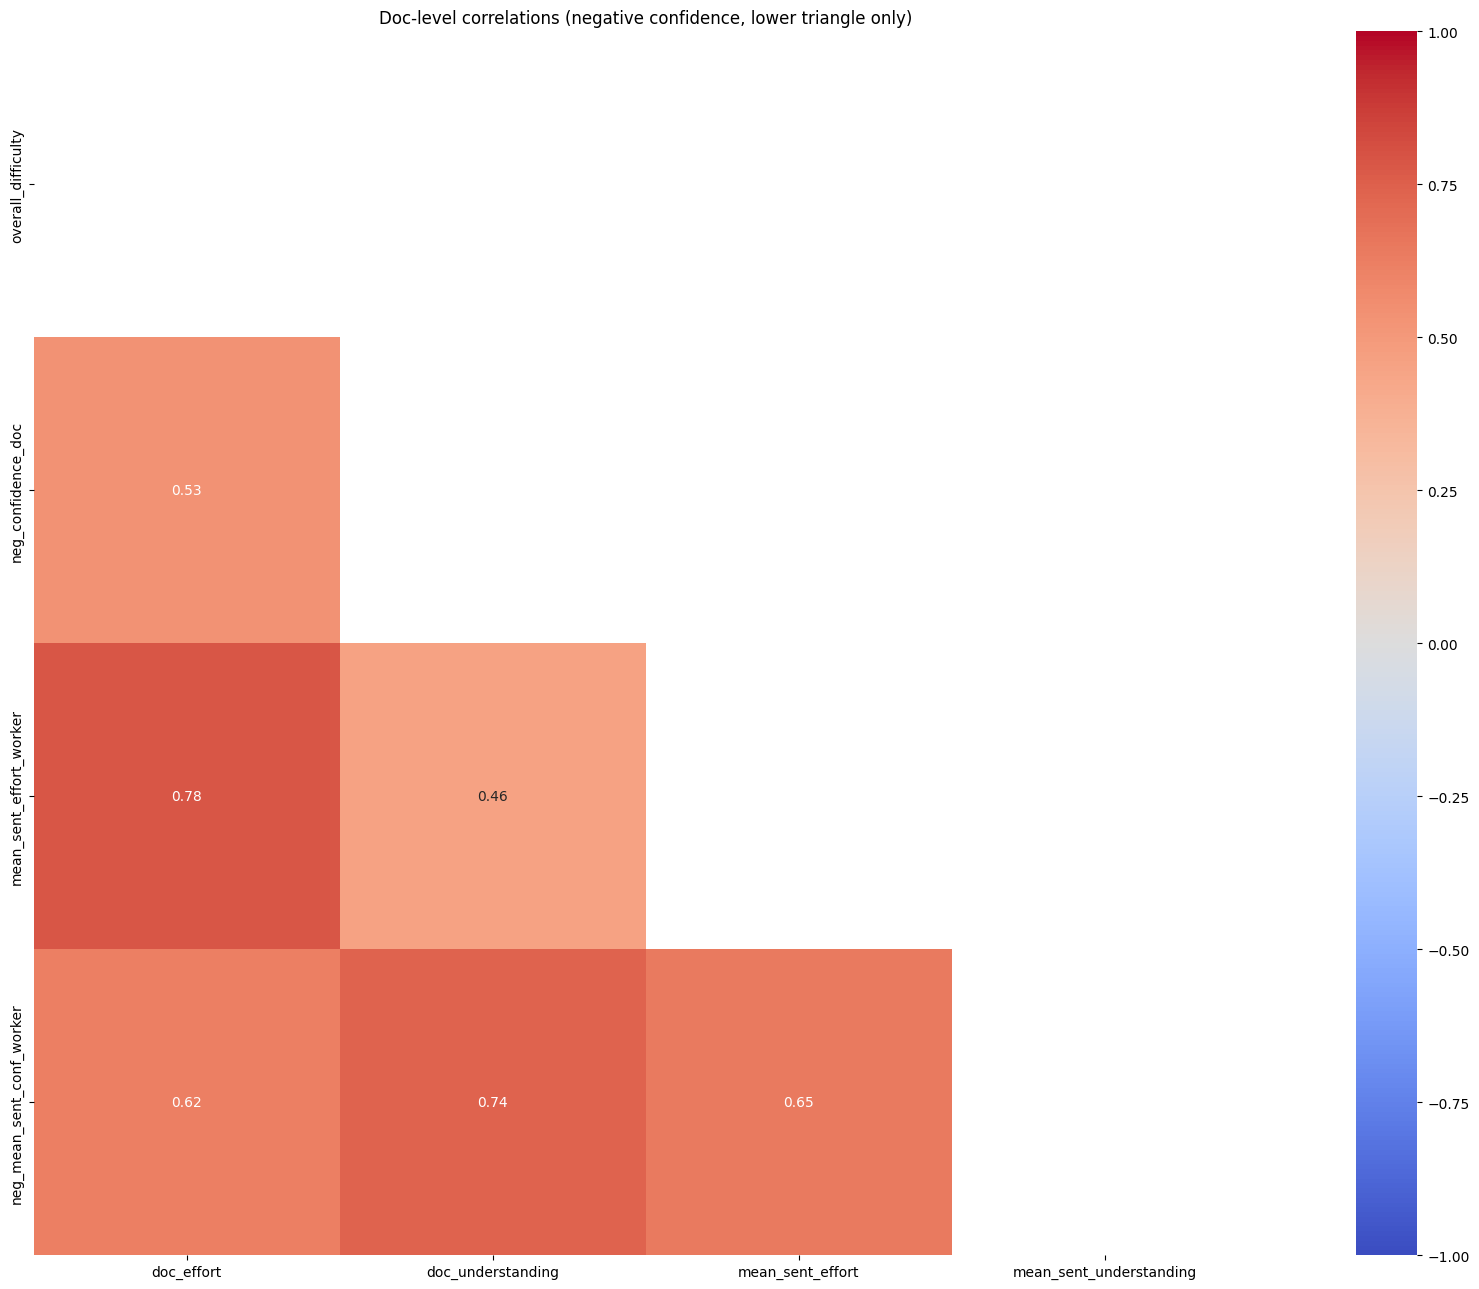

In [72]:
# features = ["overall_difficulty", "confidence_doc",
#             "mean_sent_effort_worker", "mean_sent_conf_worker"]
# corr = doc_full[features].corr()

# plt.figure(figsize=(20,13))
# sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, fmt=".2f")
# plt.title("Doc-level correlations (mean of per-worker sentence z-scores)")
# plt.tight_layout()
# plt.show()

df = doc_full.copy()

df["neg_confidence_doc"] = -df["confidence_doc"]
df["neg_mean_sent_conf_worker"] = -df["mean_sent_conf_worker"]

features = [
    "overall_difficulty",
    "neg_confidence_doc",
    "mean_sent_effort_worker",
    "neg_mean_sent_conf_worker"
]

corr = df[features].corr()
corr = corr.rename(columns={
    "overall_difficulty": "doc_effort",
    "neg_confidence_doc": "doc_understanding",
    "mean_sent_effort_worker": "mean_sent_effort",
    "neg_mean_sent_conf_worker": "mean_sent_understanding"
})

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mask out the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 13))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    fmt=".2f"
)
plt.title("Doc-level correlations (negative confidence, lower triangle only)")
plt.tight_layout()
plt.show()


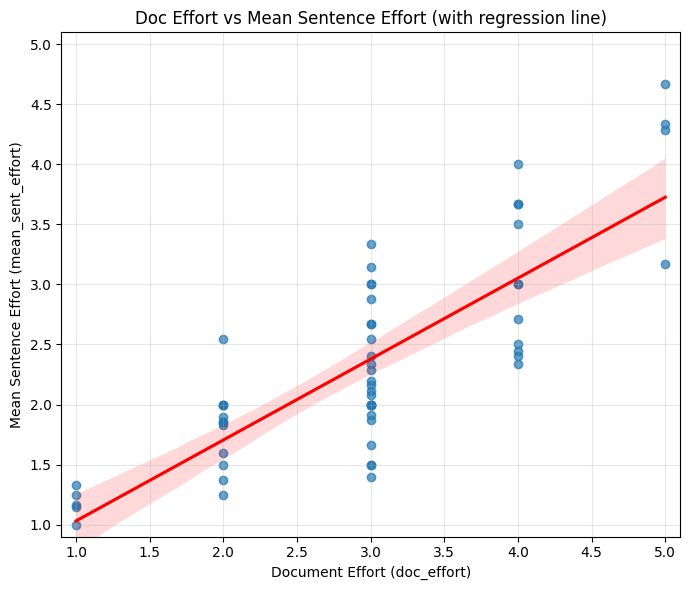

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

dfw = worker_doc_df.copy()
dfw["doc_effort"] = dfw["overall_difficulty"]
dfw["mean_sent_effort"] = dfw["mean_sent_effort_worker"]

plt.figure(figsize=(7, 6))
sns.regplot(
    data=dfw,
    x="doc_effort",
    y="mean_sent_effort",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)

plt.xlabel("Document Effort (doc_effort)")
plt.ylabel("Mean Sentence Effort (mean_sent_effort)")
plt.title("Doc Effort vs Mean Sentence Effort (with regression line)")
plt.xlim(0.9,5.1)
plt.ylim(0.9,5.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

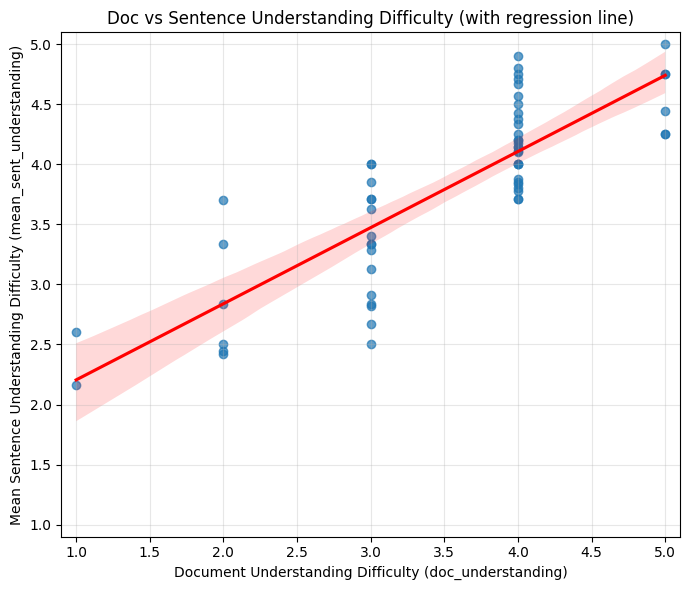

In [94]:
dfw["doc_understanding"] = dfw["confidence_doc"]
dfw["mean_sent_understanding"] = dfw["mean_sent_conf_worker"]

plt.figure(figsize=(7, 6))
sns.regplot(
    data=dfw,
    x="doc_understanding",
    y="mean_sent_understanding",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)

plt.xlabel("Document Understanding Difficulty (doc_understanding)")
plt.ylabel("Mean Sentence Understanding Difficulty (mean_sent_understanding)")
plt.title("Doc vs Sentence Understanding Difficulty (with regression line)")
plt.xlim(0.9,5.1)
plt.ylim(0.9,5.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [76]:
df["stimulus_id"].value_counts().head()

stimulus_id
text_01    1
text_02    1
text_19    1
text_18    1
text_17    1
Name: count, dtype: int64

In [39]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# 1) Per-doc averages across workers
doc_worker_mean = (
    worker_doc_df.groupby("stimulus_id")
    .agg(
        overall_difficulty_mean=("overall_difficulty", "mean"),
        confidence_doc_mean=("confidence_doc", "mean"),
        mean_sent_effort_worker=("mean_sent_effort_worker", "mean"),
        mean_sent_conf_worker=("mean_sent_conf_worker", "mean"),
        n_workers=("worker_id", "nunique"),
    )
    .reset_index()
)

# 2) Merge with doc-level features (readability, lengths, etc.)
doc_merged = doc_text_df.merge(doc_worker_mean, on="stimulus_id", how="left")


pearson correlations (rows = outcomes, cols = doc features):


,abstract_readability_avg,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
overall_difficulty_mean,0.473973,0.018766,-0.040622,-0.013798,-0.027751,0.047023,-0.027796,-0.031462,NaN,-0.052898
confidence_doc_mean,-0.326621,-0.157839,0.220665,-0.240016,-0.150901,-0.321099,-0.098594,-0.075416,NaN,-0.163970
mean_sent_effort_worker,0.582817,0.269834,-0.362666,0.277386,0.161229,0.160085,0.123151,0.116683,NaN,0.092084
mean_sent_conf_worker,-0.600253,-0.346559,0.318266,-0.390052,-0.053678,-0.403480,-0.213367,-0.288925,NaN,-0.394007


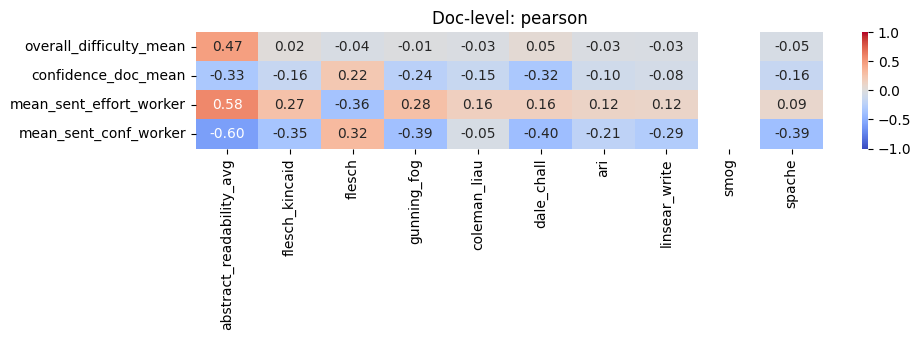


spearman correlations (rows = outcomes, cols = doc features):


,abstract_readability_avg,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
overall_difficulty_mean,0.481639,0.027058,-0.115191,0.067259,0.040201,0.029378,-0.017781,-0.075763,NaN,-0.105141
confidence_doc_mean,-0.209403,-0.180707,0.225690,-0.276102,-0.192341,-0.259815,-0.096170,-0.023267,NaN,-0.119437
mean_sent_effort_worker,0.555848,0.235427,-0.371568,0.278300,0.150433,0.094020,0.075216,0.066190,NaN,-0.001504
mean_sent_conf_worker,-0.595713,-0.376081,0.414442,-0.479128,-0.029334,-0.305378,-0.136141,-0.234675,NaN,-0.279052


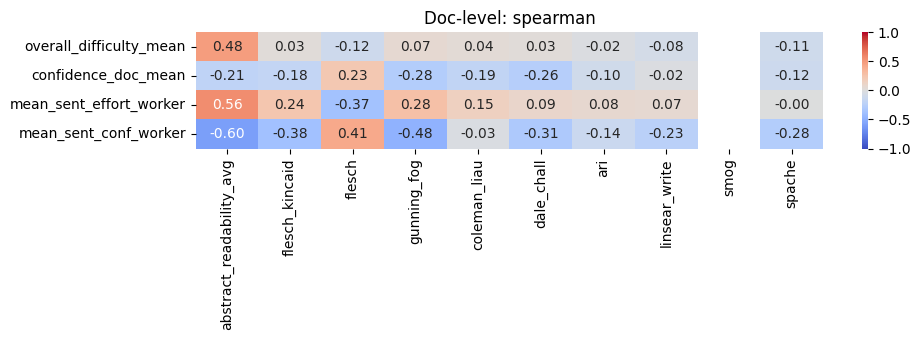


kendall correlations (rows = outcomes, cols = doc features):


,abstract_readability_avg,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
overall_difficulty_mean,0.357838,0.034629,-0.092345,0.057716,0.034629,0.000000,-0.011543,-0.046173,NaN,-0.080802
confidence_doc_mean,-0.163690,-0.140305,0.151997,-0.233842,-0.151997,-0.175382,-0.081845,-0.035076,NaN,-0.105229
mean_sent_effort_worker,0.416888,0.195251,-0.279684,0.195251,0.110818,0.089710,0.068602,0.015831,NaN,0.005277
mean_sent_conf_worker,-0.416888,-0.226914,0.269130,-0.311347,-0.036939,-0.195251,-0.079156,-0.153035,NaN,-0.184697


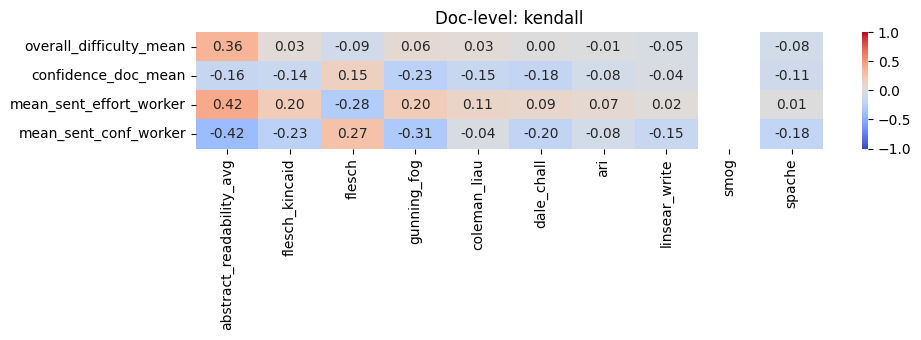

In [40]:
import seaborn as sns, matplotlib.pyplot as plt

targets = [
    "overall_difficulty_mean",
    "confidence_doc_mean",
    "mean_sent_effort_worker",
    "mean_sent_conf_worker",
]
features = [
    "abstract_readability_avg", "flesch_kincaid", "flesch", "gunning_fog",
    "coleman_liau", "dale_chall", "ari", "linsear_write", "smog", "spache"
]

available_features = [c for c in features if c in doc_merged.columns]
cols = targets + available_features
doc_corr_df = doc_merged[cols].select_dtypes(include="number")

for method in ["pearson", "spearman", "kendall"]:
    corr = doc_corr_df.corr(method=method).loc[targets, available_features]
    print(f"\n{method} correlations (rows = outcomes, cols = doc features):")
    display(corr)  # or print(corr)

    plt.figure(figsize=(0.8*len(available_features)+2, 3.5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
    plt.title(f"Doc-level: {method}")
    plt.tight_layout()
    plt.show()
